In [1]:
import numpy as np
import pandas as pd
from GENIE3 import *
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data = np.load('../../data/oversampled_data.npy', allow_pickle=True)
gene = np.load('../../data/geneAfterDiscard_0.npy', allow_pickle=True)
gene_mask = np.load('select_gene_mask.npy')

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# Select the satisfactory gene.

In [3]:
ISGnum = 60

ISGfeature = feature[:, gene_mask]
ISGgene_np = gene[gene_mask]
ISGgene_list = ISGgene_np.tolist()

# Gaussian normalization and GENIE3

In [4]:
mean = ISGfeature.mean(axis = 0)
std = ISGfeature.std(axis = 0)
ISGfeature = ISGfeature - mean
ISGfeature = ISGfeature / std


# # Genes that are used as candidate regulators
# regulators = ['CD19', 'CDH17','RAD51','OSR2','TBX3']
# VIM2 = GENIE3(data,gene_names=gene_names,regulators=regulators)

VIM = GENIE3(ISGfeature, nthreads = 8) #data,tree_method=tree_method,K=K,ntrees=ntrees, 

get_link_list(VIM, gene_names=ISGgene_list, file_name='ranking.txt') # regulators=regulators,

Tree method: RF
K: sqrt
Number of trees: 1000


running jobs on 8 threads
Elapsed time: 16.04 seconds


In [5]:
relation_rank = pd.read_csv("ranking.txt", sep = "\t", header = None)
relation_rank

,0,1,2
0,SUMO1,WDR12,0.120953
1,TRIAP1,SLC25A26,0.116228
2,TMEM14C,UCK1,0.104563
3,TRIAP1,SCAND1,0.101728
4,SCAND1,TRIAP1,0.100866
...,...,...,...
3535,SLC35F2,SLC25A26,0.002964
3536,VEGFC,SLC25A26,0.002936
3537,VAMP7,SLC25A26,0.002934
3538,SURF4,SLC25A26,0.002846


# Calculate the regulatory importance of genes.

In [6]:
weight = [0 for i in range(ISGnum)]

for i in relation_rank.index:
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 0])[0][0]] += relation_rank.iloc[i, 2]
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 1])[0][0]] += relation_rank.iloc[i, 2]

weight = np.array(weight)
weight

array([2.167093, 2.280905, 2.110824, 2.484207, 1.997261, 1.968109,
       2.387297, 1.923988, 1.648746, 1.669957, 2.717479, 1.887024,
       1.986811, 1.845417, 1.772913, 1.847705, 2.019874, 1.858553,
       2.020892, 1.772977, 1.734916, 2.338844, 2.322855, 1.670083,
       1.665519, 1.569618, 2.003808, 2.158625, 2.053928, 2.212545,
       2.682602, 1.850354, 1.96914 , 1.9016  , 1.963587, 1.931527,
       2.307196, 1.77978 , 2.11879 , 1.768081, 2.006288, 2.096641,
       1.98265 , 1.807854, 2.520447, 1.801226, 2.200377, 2.518852,
       1.671399, 1.739373, 1.813334, 1.586481, 1.90141 , 2.376566,
       1.815458, 1.786816, 1.799926, 2.164437, 1.849332, 1.779507])

# Genes are sorted in ascending order according to regulatory importance.

In [7]:
order_idx = np.argsort(weight)

order_gene = ISGgene_np[order_idx]
np.savetxt('genie3_order_gene.txt', np.c_[order_gene], fmt='%s',delimiter='\t')
order_gene

array(['TCTA', 'VAMP7', 'SLC23A2', 'SYT8', 'SLC25A25', 'SURF4', 'UPRT',
       'STRA6', 'USP13', 'TUBB2B', 'SPAG1', 'STK25', 'WDR41', 'TTC8',
       'WBP4', 'WDR12', 'UCK1', 'UBE4B', 'USP33', 'VNN1', 'SLC35F2',
       'SPATA17', 'WDR26', 'TRIB3', 'SRRT', 'SLC25A40', 'VASH1', 'TRIM39',
       'SEC63', 'TRPV4', 'TRMT12', 'SDSL', 'TRIM36', 'UBE2Z', 'SLC35A1',
       'SCRN1', 'TLCD1', 'TYK2', 'SPCS1', 'SSSCA1', 'TMEM14C', 'UBE2D1',
       'SARM1', 'TTLL11', 'TMED3', 'WDR25', 'RWDD2A', 'UFSP2', 'TMEM160',
       'SAR1A', 'TSSC4', 'SUPT3H', 'SUMO1', 'VEGFC', 'SEC61G', 'SCAND1',
       'UPF1', 'UBXN1', 'TRIAP1', 'SLC25A26'], dtype=object)

In [8]:
feature_after_GENIE3 = ISGfeature[:, order_idx]
feature_after_GENIE3.shape

(296, 60)

# Run the feature elimination algorithm.

In [9]:
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [17]:
reserved_gene_idx = []
alternative_gene_idx = [i for i in range(order_gene.shape[0])]

init_acc = 0

geneNum = []
acc = []
prec = []
rec = []
auc = []

times = order_gene.shape[0]

# train-test split    random_state=2022
X_train, X_test, y_train, y_test = train_test_split(genie3后选出的特征, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(times):
    
    geneNum.append(i + 1)
    reserved_gene_idx += [alternative_gene_idx[i]]
    
    xTrain = X_train[:, np.array(reserved_gene_idx)]
    xTest = X_test[:, np.array(reserved_gene_idx)]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []
    
    for _ in range(5):
        rf = RandomForestClassifier()
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)
        
        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))

    if np.array(allAcc).mean() > init_acc:
        init_acc = np.array(allAcc).mean()
        
        acc.append(np.array(allAcc).mean())
        prec.append(np.array(allPrec).mean())
        rec.append(np.array(allRec).mean())
        auc.append(np.array(allAuc).mean())
    else:
        reserved_gene_idx.remove(alternative_gene_idx[i])
        
        
geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

feature_elimination_path = "performance/feature_elimination_genie3_asc_"

np.save(feature_elimination_path + "acc.npy", acc)
np.save(feature_elimination_path + "prec.npy", prec)
np.save(feature_elimination_path + "rec.npy", rec)
np.save(feature_elimination_path + "auc.npy", auc)

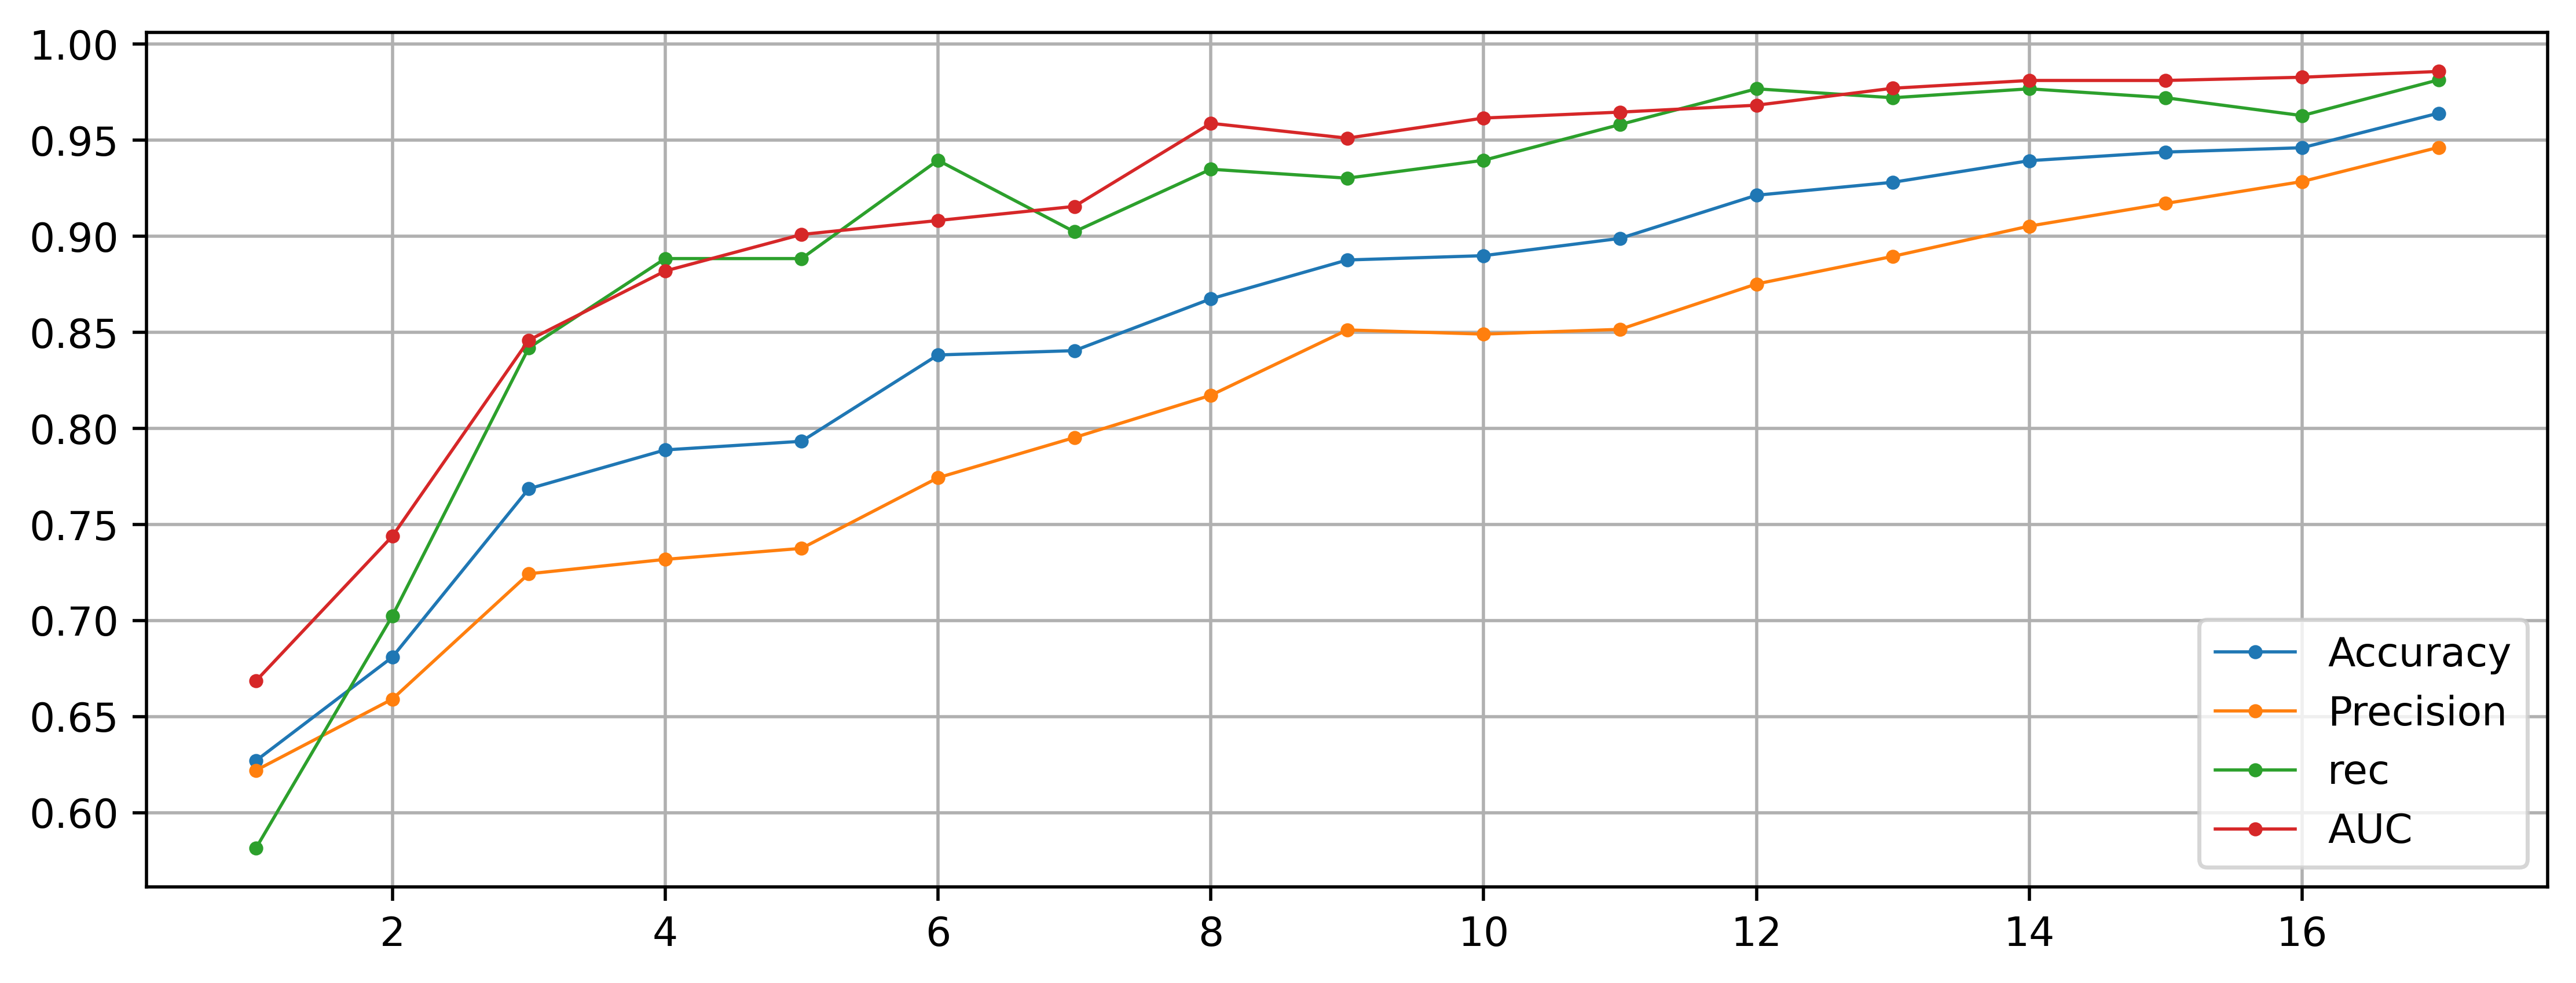

In [19]:
ISGnum = bar = len(acc)

pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)

markersize = 5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)


plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

In [20]:
checkPoint = ISGnum - 1
print('{}\t{}\t{}\t{}\t{}'.format(ISGnum, acc[checkPoint], prec[checkPoint], rec[checkPoint],  auc[checkPoint]))

17	0.9640449438202247	0.9462626262626262	0.9813953488372092	0.985793731041456
